In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import time
import os
import re
import gc
import tsfresh
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import chi2
from yellowbrick.cluster import KElbowVisualizer
from lightgbm import LGBMRegressor, LGBMClassifier
import lightgbm as lgbm
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.frequent_patterns import apriori, association_rules
import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow as tf
from scipy import stats
from tqdm import tqdm
from hcuppy.ccs import CCSEngine
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.float_format', lambda num:'%1.3f'%num)
pd.set_option('display.max_columns', 99)
np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
def query_db(query):    
    
    connection = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=hex6\hex6;DATABASE=AIML;Trusted_Connection=yes;')
    cur = connection.cursor()
    cur.execute(query)
    rows = cur.fetchall()
    rows = pd.DataFrame(rows)
    
    return rows

In [4]:
query_for_train = """
        SELECT a.* ,b.QRTR
        FROM [AIML].[dbo].[Expenditure_Prediction]a
        LEFT JOIN [AIML].[dbo].[BI_DT_DIM]b
        ON a.Anchordate = b.CalDT
        WHERE AnchorDate <= '2019-11-30'
        AND [MedicareStatus] = 'AgedNonDual'
        ORDER BY Memberid, Anchordate
        """

query_for_test1 = """
        SELECT a.* ,b.QRTR
        FROM [AIML].[dbo].[Expenditure_Prediction]a
        LEFT JOIN [AIML].[dbo].[BI_DT_DIM]b
        ON a.Anchordate = b.CalDT
        WHERE AnchorDate IN ('2019-12-31')
        AND [MedicareStatus] = 'AgedNonDual'
        ORDER BY Memberid, Anchordate
        """

In [5]:
raw_train = query_db(query_for_train)
raw_test1 = query_db(query_for_test1)

In [6]:
def filter_data(df, columns):
    
    map_gender = {'Male':0, 'Female':1}
    map_race = {'White':0, 'HISpanic':1, 'Asian':2, 'Black':3, 'Native American':4, 'Other':5, 'Unknown':6}
    HCC_map = {'No':0, 'Yes':1}
    
    for i, col in enumerate(columns):
        df[col] = df[0].apply(lambda x: x[i])
    df = df.drop([0], axis=1)
    
    for col in ['Anchordate', 'DOB']:
        df[col] = pd.to_datetime(df[col])    
    
    df.insert(1, 'Year', df['Anchordate'].dt.year)
    df.insert(2, 'Month', df['Anchordate'].dt.month)
    df.insert(3, 'YOB', df['DOB'].dt.year)
    df = df.rename(columns={'Memberid':'MemberID'})    
    df['MemberGender'] = df['MemberGender'].map(map_gender)
    df['MemberRace'] = df['MemberRace'].map(map_race)
    
    for col in columns:
        if col.__contains__('HCC'):
            df[col] = df[col].map(HCC_map)
    
    return df

In [7]:
columns = ['Memberid', 'Anchordate', 'First CLaim Date',
       'First Claim Date In 12 Months Period', 'DOB', 'AGE', 'MemberGender',
       'MemberRace', 'MedicareStatus', 'ZipCode', 'Expenditure',
       'Monthly Expenditure', 'Threshold Expenditure', 'Total Expenditure',
       'Threshold Expenditure IND', 'Total Claims', 'PART A CLAIMS',
       'PART B CLAIMS', 'PART D CLAIMS', 'ED_Vists',
          'Admissions', 'PCP_Visits', 'RISK SCORE', 'SNF COUNT', 'HOSPITAL LOS',
       'HOSPICE IND', 'HCC_1', 'HCC_2', 'HCC_6', 'HCC_8', 'HCC_9', 'HCC_10',
       'HCC_11', 'HCC_12', 'HCC_17', 'HCC_18', 'HCC_19', 'HCC_21', 'HCC_22',
       'HCC_23', 'HCC_27', 'HCC_28', 'HCC_29', 'HCC_33', 'HCC_34', 'HCC_35', 'HCC_39',
       'HCC_40', 'HCC_46', 'HCC_47', 'HCC_48', 'HCC_51', 'HCC_52', 'HCC_55',
       'HCC_56', 'HCC_57', 'HCC_58', 'HCC_59', 'HCC_60', 'HCC_70',
          'HCC_71', 'HCC_72', 'HCC_73', 'HCC_74', 'HCC_75', 'HCC_76', 'HCC_77',
       'HCC_78', 'HCC_79', 'HCC_80', 'HCC_82', 'HCC_83', 'HCC_84', 'HCC_85',
       'HCC_86', 'HCC_87', 'HCC_88', 'HCC_96', 'HCC_99', 'HCC_100',
          'HCC_103', 'HCC_104', 'HCC_106', 'HCC_107', 'HCC_108', 'HCC_110',
       'HCC_111', 'HCC_112', 'HCC_114', 'HCC_115', 'HCC_122', 'HCC_124',
       'HCC_134', 'HCC_135', 'HCC_136', 'HCC_137', 'HCC_138', 'HCC_157',
       'HCC_158', 'HCC_159', 'HCC_161', 'HCC_162', 'HCC_166', 'HCC_167',
       'HCC_169', 'HCC_170', 'HCC_173', 'HCC_176', 'QRTR']
df_for_train = filter_data(raw_train, columns)
df_for_test1 = filter_data(raw_test1, columns)
test_columns = df_for_test1.drop(['MemberID', 'Year', 'Month'], axis=1).columns

for col in test_columns:
    df_for_test1[col] = df_for_test1[col].apply(lambda x: np.nan)

In [8]:
df_for_train[['Monthly Expenditure', 'Threshold Expenditure']] = df_for_train[['Monthly Expenditure', 'Threshold Expenditure']].astype(float)
df_for_train['Threshold Expenditure'] = df_for_train['Threshold Expenditure']/12
df_for_train = df_for_train.fillna(0)
df_for_train['Monthly Expenditure'] = df_for_train[['Monthly Expenditure', 'Threshold Expenditure']].apply(lambda x: x['Monthly Expenditure'] if x['Monthly Expenditure']<x['Threshold Expenditure']
                                                                                                          else x['Threshold Expenditure'], axis=1)
quarterly_exp_df = df_for_train.groupby(['MemberID', 'QRTR'], as_index=False)['Monthly Expenditure'].sum()
quarterly_exp_df = quarterly_exp_df.rename(columns={'Monthly Expenditure':'Quarterly Expenditure'})
df_for_train = df_for_train.merge(quarterly_exp_df, how='left', left_on=['MemberID', 'QRTR'], right_on=['MemberID', 'QRTR'])
df_for_train = df_for_train[(df_for_train['Month']==3)|(df_for_train['Month']==6)|(df_for_train['Month']==9)|(df_for_train['Month']==12)]

In [9]:
df_for_test1['Quarterly Expenditure'] = np.nan
drop_columns = ['Anchordate', 'First CLaim Date', 'DOB', 'AGE', 'MedicareStatus',
                'First Claim Date In 12 Months Period', 'MedicareStatus',
                'Expenditure', 'Monthly Expenditure', 'Threshold Expenditure', 'Total Expenditure',
               'Threshold Expenditure IND', 'HOSPICE IND', 'QRTR']
df_for_train = df_for_train.drop(drop_columns, axis=1)
df_for_test1 = df_for_test1.drop(drop_columns, axis=1)
df_for_train = df_for_train.rename(columns={'Quarterly Expenditure':'Expenditure'})
df_for_test1 = df_for_test1.rename(columns={'Quarterly Expenditure':'Expenditure'})

In [10]:
# df_for_train[df_for_train['Expenditure'].isnull()]
df_for_train = df_for_train.fillna(0)
df_for_train['Expenditure'] = df_for_train['Expenditure'].astype(float)
label_encode = LabelEncoder()
df_for_train['ZipCode'] = label_encode.fit_transform(df_for_train['ZipCode'])

## 1. Feature Engineering

In [11]:
def shift_additional_feature(data, additional_features, shift_windows = [1]):    
    
    for i in shift_windows:
        for feature in tqdm(additional_features):
            data[feature] = data.groupby(['MemberID'], as_index=False)[feature].transform(lambda x: x.shift(i))
        
    return data

In [12]:
def create_tsf(data, column):
    
    shift_windows = [0]
    shift_windows1 = [1]    
    rolling_windows = [2,3,4]    
    EWF_windows = [2,3,4]    
        
    for i in shift_windows1:
        data[column+'_lag_'+str(i)] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i))            
             
    for i in shift_windows:
        for j in tqdm(rolling_windows):
            data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_mean'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).mean())            
#             data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_std'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).std())
            data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_sum'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).sum())   
            data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_median'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).median()) 
#             data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_var'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).var())   
            data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_max'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).max())   
            data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_min'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).min())   
            
    for i in shift_windows:
        for j in tqdm(EWF_windows):
            data[column+'_shift_'+str(i)+'_ewf_'+str(j)+'_mean'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).ewm(span=j, min_periods=1).mean())            
            data[column+'_shift_'+str(i)+'_ewf_'+str(j)+'_std'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).ewm(span=j, min_periods=1).std())            
    
    return data

In [13]:
additional_features = df_for_train.drop(['MemberID', 'Year', 'Month', 'Expenditure'], axis=1).columns
df_for_train1 = df_for_train.copy()
df_for_train1 = shift_additional_feature(df_for_train1, additional_features)

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [04:59<00:00,  3.12s/it]


In [14]:
start = time.time()
df_for_train1 = create_tsf(df_for_train1, 'Expenditure')
end = time.time()
time_executed = end - start
print(time_executed)
df_for_train1 = df_for_train1.dropna()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:35<00:00, 11.90s/it]

119.77827668190002


In [15]:
df_for_train1.shape

(31284, 122)

## 2. Time Series Model

In [16]:
def make_train_validation_set(df, Year_for_val, Month_for_val):
    
    df = df.reset_index()
    index_val = df[(df['Year']==Year_for_val)&(df['Month']==Month_for_val)]['index']
    df_train = df[~df['index'].isin(index_val)]
    df_val = df[(df['Year']==Year_for_val)&(df['Month']==Month_for_val)]
    X_train = df_train.drop(['index','MemberID','Expenditure'], axis=1)
    y_train = df_train['Expenditure']
    X_val = df_val.drop(['index','MemberID','Expenditure'], axis=1)
    y_val = df_val['Expenditure']
    
    return X_train, y_train, X_val, y_val

In [17]:
X_train, y_train, X_val, y_val = make_train_validation_set(df_for_train1, Year_for_val=2019, Month_for_val=9)

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)

MinMaxScaler()

In [19]:
def build_model(model_name, LSTM_input_shape=None): # LSTM_input_shape=[1, X_train.shape[1]]
    
    if model_name == 'LGBM':
        lgb_params = {      'boosting_type': 'gbdt',
                    'max_depth':4,                    
                    'metric': 'rmse',
                    'subsample': 1,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'num_leaves': 6,
                    'reg_alpha':0,
                    'reg_lambda':0,
                    'colsample_bytree':0.5,
                    'random_state':18,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 5000,
                    'boost_from_average': True,
                    'verbose': -1,
                }
        LGBM_model = LGBMRegressor(**lgb_params)
        return LGBM_model
    
    elif model_name == 'LSTM':
        LSTM_model = keras.Sequential()
        LSTM_model.add(keras.layers.LSTM(
                  units=100,          
                  input_shape=LSTM_input_shape,
        #     kernel_initializer='he_normal',
        #     use_bias=False,    
                  recurrent_dropout=0.5,
                  return_sequences=True,
        #     unroll=True
              )    
        )
        LSTM_model.add(keras.layers.LSTM(
                  units=20,                    
        #     kernel_initializer='he_normal',
        #     use_bias=False,              
                  return_sequences=True,
        #     recurrent_dropout=0.2,
        #     unroll=True
              )    
        )
        LSTM_model.add(keras.layers.LSTM(
                  units=100,                    
        #     kernel_initializer='he_normal',
        #     use_bias=False,              
                  return_sequences=True,
        #     recurrent_dropout=0.2,
        #     unroll=True
              )    
        )
        LSTM_model.add(keras.layers.Dense(units=1, activation='linear'))

        # opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam")

        LSTM_model.compile(
          loss='mean_squared_error',  
          optimizer='adam'
        )
        return LSTM_model

In [20]:
def create_dataset_sequence(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X), step):
#         v = X.iloc[i:(i + time_steps)].values
        v = X[i:(i + time_steps),:]
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [21]:
def decay_schedule(epoch, lr):
    
    if (epoch % 5 == 0) and (epoch != 0):
        lr = lr * 0.2
        
    return lr

In [22]:
def training(df, model, X_train, y_train, X_val, y_val, batch_size=16):
    
    if model == LGBM_model:
        LGBM_model.fit(X_train, y_train, eval_set=[(X_train,y_train), (X_val,y_val)], verbose=2, early_stopping_rounds=10)
        return LGBM_model
    
    elif model == LSTM_model:
        X_train1  = scaler.fit_transform(X_train)
        y_train1 = (y_train - y_train.min()) / (y_train.max() - y_train.min())
        X_val1  = scaler.transform(X_val)
        y_val1 = (y_val - y_train.min()) / (y_train.max() - y_train.min())
        X_train1, y_train1 = create_dataset_sequence(X_train1, y_train1)
        X_val1, y_val1 = create_dataset_sequence(X_val1, y_val1)
        
        lr_scheduler = LearningRateScheduler(decay_schedule)
        callbacks = [EarlyStopping(monitor='val_loss', patience=4),
                     lr_scheduler,
        #              ModelCheckpoint(filepath='F:/Chung/ML for Netrin data/LSTM_model', monitor='val_loss', save_best_only=True)
                    ]        

        history = LSTM_model.fit(
            X_train1, y_train1,
            epochs=100,
            callbacks=callbacks,
            batch_size=batch_size,    
            shuffle=False,
            validation_data=(X_val1, y_val1)
        )
        
        y_val_predict = LSTM_model.predict(X_val1, batch_size=batch_size)
        y_val_predict = y_val_predict[:,0,0]
        y_val_predict = y_val_predict*(y_train.max()-y_train.min()) + y_train.min()
        LSTM_rmse = np.sqrt(mean_squared_error(y_val_predict, y_val))
        return LSTM_model, LSTM_rmse

In [23]:
def LGBM_feature_importance(feature_names, LGBM_model):
    
    fe_imp_score = sorted(zip(LGBM_model.booster_.feature_importance(importance_type='gain'), feature_names), reverse=True)
    fe_imp_df = pd.DataFrame({'model_result': fe_imp_score})
    fe_imp_df['score'] = fe_imp_df['model_result'].apply(lambda x: x[0])
    fe_imp_df['feature'] = fe_imp_df['model_result'].apply(lambda x: x[1])
    
    data = fe_imp_df['score']
    labels = fe_imp_df['feature']
    colors = sns.color_palette('pastel')[0:3]
    plt.figure(1 , figsize = (8 , 8))
    plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
    plt.show()
    
    return fe_imp_score

**LGBM Model**

In [24]:
LGBM_model = build_model('LGBM')

In [25]:
LGBM_model = training(df_for_train1, LGBM_model, X_train, y_train, X_val, y_val)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5
[2]	training's rmse: 4687.71	valid_1's rmse: 4560.41
[4]	training's rmse: 4606.86	valid_1's rmse: 4484.42
[6]	training's rmse: 4526.74	valid_1's rmse: 4408.55
[8]	training's rmse: 4448.77	valid_1's rmse: 4334.83
[10]	training's rmse: 4374.07	valid_1's rmse: 4264.49
[12]	training's rmse: 4299.95	valid_1's rmse: 4192.25
[14]	training's rmse: 4226.27	valid_1's rmse: 4122.76
[16]	training's rmse: 4151.78	valid_1's rmse: 4051.23
[18]	training's rmse: 4083.9	valid_1's rmse: 3987.96
[20]	training's rmse: 4015.81	valid_1's rmse: 3920.88
[22]	training's rmse: 3945.92	valid_1's rmse: 3853.34
[24]	training's rmse: 3880.61	valid_1's rmse: 3791.19
[26]	training's rmse: 3816.6	valid_1's rmse: 3731.02
[28]	training's rmse: 3755.6	valid_1's rmse: 3674.4
[30]	training's rmse: 3693.95	valid_1's rmse: 3616.95
[32]	training's rmse: 3630.86	valid_1's rmse: 3556.76
[34]	training's rmse

[454]	training's rmse: 633.695	valid_1's rmse: 718.116
[456]	training's rmse: 630.772	valid_1's rmse: 714.949
[458]	training's rmse: 628.993	valid_1's rmse: 712.481
[460]	training's rmse: 626.685	valid_1's rmse: 709.923
[462]	training's rmse: 625.116	valid_1's rmse: 708.38
[464]	training's rmse: 623.31	valid_1's rmse: 706.656
[466]	training's rmse: 621.593	valid_1's rmse: 704.9
[468]	training's rmse: 619.678	valid_1's rmse: 702.87
[470]	training's rmse: 617.537	valid_1's rmse: 700.635
[472]	training's rmse: 615.711	valid_1's rmse: 698.583
[474]	training's rmse: 614.334	valid_1's rmse: 696.83
[476]	training's rmse: 612.439	valid_1's rmse: 694.838
[478]	training's rmse: 609.796	valid_1's rmse: 692.204
[480]	training's rmse: 607.707	valid_1's rmse: 689.532
[482]	training's rmse: 606.261	valid_1's rmse: 687.755
[484]	training's rmse: 604.78	valid_1's rmse: 686.185
[486]	training's rmse: 603.231	valid_1's rmse: 684.683
[488]	training's rmse: 602.241	valid_1's rmse: 683.584
[490]	training's 

[800]	training's rmse: 436.152	valid_1's rmse: 495.265
[802]	training's rmse: 435.59	valid_1's rmse: 494.636
[804]	training's rmse: 434.89	valid_1's rmse: 493.99
[806]	training's rmse: 434.365	valid_1's rmse: 493.284
[808]	training's rmse: 433.686	valid_1's rmse: 492.361
[810]	training's rmse: 433.18	valid_1's rmse: 491.651
[812]	training's rmse: 432.59	valid_1's rmse: 490.951
[814]	training's rmse: 431.836	valid_1's rmse: 490.294
[816]	training's rmse: 431.535	valid_1's rmse: 490.085
[818]	training's rmse: 431.124	valid_1's rmse: 489.535
[820]	training's rmse: 430.64	valid_1's rmse: 488.92
[822]	training's rmse: 430.027	valid_1's rmse: 488.472
[824]	training's rmse: 429.532	valid_1's rmse: 487.817
[826]	training's rmse: 429.142	valid_1's rmse: 487.643
[828]	training's rmse: 428.681	valid_1's rmse: 486.987
[830]	training's rmse: 428.186	valid_1's rmse: 486.467
[832]	training's rmse: 427.663	valid_1's rmse: 485.743
[834]	training's rmse: 427.047	valid_1's rmse: 485.073
[836]	training's 

[1160]	training's rmse: 372.93	valid_1's rmse: 429.874
[1162]	training's rmse: 372.671	valid_1's rmse: 429.63
[1164]	training's rmse: 372.484	valid_1's rmse: 429.451
[1166]	training's rmse: 372.264	valid_1's rmse: 429.165
[1168]	training's rmse: 371.918	valid_1's rmse: 428.771
[1170]	training's rmse: 371.717	valid_1's rmse: 428.683
[1172]	training's rmse: 371.534	valid_1's rmse: 428.466
[1174]	training's rmse: 371.313	valid_1's rmse: 428.374
[1176]	training's rmse: 371.058	valid_1's rmse: 428.255
[1178]	training's rmse: 370.844	valid_1's rmse: 428.122
[1180]	training's rmse: 370.645	valid_1's rmse: 428.05
[1182]	training's rmse: 370.464	valid_1's rmse: 427.91
[1184]	training's rmse: 370.229	valid_1's rmse: 427.602
[1186]	training's rmse: 369.906	valid_1's rmse: 427.384
[1188]	training's rmse: 369.693	valid_1's rmse: 427.276
[1190]	training's rmse: 369.447	valid_1's rmse: 427.046
[1192]	training's rmse: 369.23	valid_1's rmse: 426.769
[1194]	training's rmse: 368.975	valid_1's rmse: 426.5

[1542]	training's rmse: 336.738	valid_1's rmse: 402.864
[1544]	training's rmse: 336.645	valid_1's rmse: 402.751
[1546]	training's rmse: 336.504	valid_1's rmse: 402.707
[1548]	training's rmse: 336.38	valid_1's rmse: 402.633
[1550]	training's rmse: 336.194	valid_1's rmse: 402.464
[1552]	training's rmse: 336.042	valid_1's rmse: 402.357
[1554]	training's rmse: 335.853	valid_1's rmse: 402.074
[1556]	training's rmse: 335.681	valid_1's rmse: 401.879
[1558]	training's rmse: 335.534	valid_1's rmse: 401.743
[1560]	training's rmse: 335.356	valid_1's rmse: 401.605
[1562]	training's rmse: 335.266	valid_1's rmse: 401.569
[1564]	training's rmse: 335.068	valid_1's rmse: 401.492
[1566]	training's rmse: 334.976	valid_1's rmse: 401.391
[1568]	training's rmse: 334.768	valid_1's rmse: 401.269
[1570]	training's rmse: 334.578	valid_1's rmse: 401.114
[1572]	training's rmse: 334.349	valid_1's rmse: 401.023
[1574]	training's rmse: 334.206	valid_1's rmse: 400.896
[1576]	training's rmse: 333.986	valid_1's rmse: 4

[1938]	training's rmse: 310.129	valid_1's rmse: 388.825
[1940]	training's rmse: 310.04	valid_1's rmse: 388.798
[1942]	training's rmse: 309.852	valid_1's rmse: 388.735
[1944]	training's rmse: 309.525	valid_1's rmse: 388.59
[1946]	training's rmse: 309.407	valid_1's rmse: 388.576
[1948]	training's rmse: 309.308	valid_1's rmse: 388.463
[1950]	training's rmse: 309.172	valid_1's rmse: 388.371
[1952]	training's rmse: 309.103	valid_1's rmse: 388.342
[1954]	training's rmse: 309.013	valid_1's rmse: 388.282
[1956]	training's rmse: 308.805	valid_1's rmse: 388.276
[1958]	training's rmse: 308.676	valid_1's rmse: 388.135
[1960]	training's rmse: 308.461	valid_1's rmse: 387.998
[1962]	training's rmse: 308.378	valid_1's rmse: 387.874
[1964]	training's rmse: 308.318	valid_1's rmse: 387.809
[1966]	training's rmse: 308.235	valid_1's rmse: 387.695
[1968]	training's rmse: 308.096	valid_1's rmse: 387.643
[1970]	training's rmse: 307.978	valid_1's rmse: 387.626
[1972]	training's rmse: 307.888	valid_1's rmse: 38

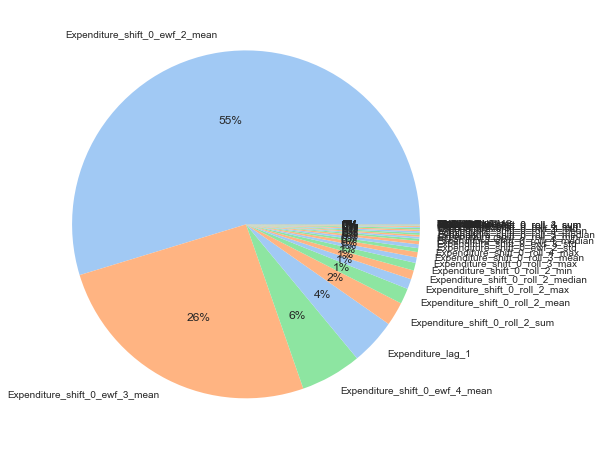

In [26]:
fe_imp_score = LGBM_feature_importance(df_for_train1.drop(['MemberID','Expenditure'], axis=1).columns, LGBM_model)

In [27]:
fe_imp_score

[(16273588062536.0, 'Expenditure_shift_0_ewf_2_mean'),
 (7622977552724.0, 'Expenditure_shift_0_ewf_3_mean'),
 (1686602819668.0, 'Expenditure_shift_0_ewf_4_mean'),
 (1274048137562.0, 'Expenditure_lag_1'),
 (655849956196.0, 'Expenditure_shift_0_roll_2_sum'),
 (431864646448.0, 'Expenditure_shift_0_roll_2_mean'),
 (279966040420.0, 'Expenditure_shift_0_roll_2_max'),
 (246948352926.0, 'Expenditure_shift_0_roll_2_median'),
 (211604146752.0, 'Expenditure_shift_0_roll_2_min'),
 (153066758968.0, 'Expenditure_shift_0_roll_3_max'),
 (147664819064.0, 'Expenditure_shift_0_roll_3_mean'),
 (108580860446.0, 'Expenditure_shift_0_roll_4_max'),
 (105442577214.30078, 'Expenditure_shift_0_ewf_2_std'),
 (91350566288.0, 'Expenditure_shift_0_ewf_3_std'),
 (62306993718.0, 'Expenditure_shift_0_roll_4_median'),
 (53483320630.0, 'HOSPITAL LOS'),
 (50840535798.0, 'Expenditure_shift_0_roll_3_min'),
 (50452124358.0, 'Expenditure_shift_0_roll_3_median'),
 (49908315570.0, 'Admissions'),
 (45085964162.0, 'Expenditure_sh

----------

**Long Short Term Memory (LSTM) Model**

In [28]:
LSTM_model = build_model('LSTM', LSTM_input_shape=[1, X_train.shape[1]])

In [29]:
LSTM_model, LSTM_rmse = training(df_for_train1, LSTM_model, X_train, y_train, X_val, y_val, batch_size=16)

Epoch 1/100
1630/1630 [==============================] - 15s 5ms/step - loss: 0.0020 - val_loss: 2.0815e-04
Epoch 2/100
1630/1630 [==============================] - 8s 5ms/step - loss: 1.8039e-04 - val_loss: 1.6746e-04
Epoch 3/100
1630/1630 [==============================] - 8s 5ms/step - loss: 2.3363e-04 - val_loss: 9.9611e-05
Epoch 4/100
1630/1630 [==============================] - 8s 5ms/step - loss: 1.5825e-04 - val_loss: 6.1865e-05
Epoch 5/100
1630/1630 [==============================] - 8s 5ms/step - loss: 1.9419e-04 - val_loss: 9.3340e-05
Epoch 6/100
1630/1630 [==============================] - 8s 5ms/step - loss: 2.7299e-05 - val_loss: 2.4551e-05
Epoch 7/100
1630/1630 [==============================] - 8s 5ms/step - loss: 1.9800e-05 - val_loss: 2.1368e-05
Epoch 8/100
1630/1630 [==============================] - 8s 5ms/step - loss: 1.6754e-05 - val_loss: 1.8799e-05
Epoch 9/100
1630/1630 [==============================] - 7s 5ms/step - loss: 1.4385e-05 - val_loss: 1.6688e-05
Epoc

In [30]:
LSTM_rmse

119.83479645351045

## 3. Prediction

In [31]:
def concat_df_for_prediction(df, future_df, Year, Month, features):
    
    future_df_temp = future_df[future_df['Month']==Month]
    future_df_predict = future_df_temp.copy()
    memberID_future = future_df_temp['MemberID'].unique()
    
    for col in features:
        future_df_predict[col] = np.nan
        
    df_for_predict = df[df['MemberID'].isin(memberID_future)]
    df_for_predict = pd.concat((df_for_predict, future_df_predict))
    df_for_predict_final = df_for_predict.groupby(['MemberID','Year','Month'], as_index=False)['Expenditure'].sum()
    
    for col in features:
        temp = df_for_predict.groupby(['MemberID','Year','Month'], as_index=False)[col].sum()
        temp.loc[(temp['Year']==Year)&(temp['Month']==Month), col] = np.nan
        df_for_predict_final[col] = temp[col]
        
    return df_for_predict_final

In [32]:
def predicting(old_df, feature_list, Year, Month, model, batch_size=16, columns_shift=additional_features):
    
    temp = old_df.copy()
    temp = create_tsf(temp, 'Expenditure')        
    temp = shift_additional_feature(temp, columns_shift)
        
    X_predict = temp[(temp['Year']==Year)&(temp['Month']==Month)][feature_list]
    
    if model != LSTM_model:
        y_predict = model.predict(X_predict)
    else:
        X_predict1 = scaler.transform(X_predict)        
        X_predict1 = np.array(X_predict1).reshape(X_predict1.shape[0],1,X_predict1.shape[1])
        y_predict = model.predict(X_predict1, batch_size=batch_size)        
    
    return y_predict

In [33]:
def concat_prediction_to_df(df_to_last_month, df_for_predict_previous, last_month_prediction, Year, Month):
    
    temp = df_for_predict_previous[(df_for_predict_previous['Year']==Year)&(df_for_predict_previous['Month']==Month)]
    temp['Expenditure'] = last_month_prediction
    temp = pd.concat((df_to_last_month,temp))
    temp = temp.groupby(['MemberID','Year','Month'], as_index=False)['Expenditure'].sum()
    member_id1 = df_for_predict_previous.MemberID.unique()
    temp = temp[temp['MemberID'].isin(member_id1)]
    temp = temp.reset_index(drop=True)
    
    temp1 = df_for_predict_previous.copy()
    columns = ['ZipCode','YOB','MemberGender','MemberRace']

    for col in columns:
        temp1[col] = temp1.groupby(['MemberID'], as_index=False)[col].transform(lambda x: x.shift(1))

    temp1 = temp1.reset_index(drop=True)    
    temp2 = pd.concat((temp, temp1[['ZipCode','YOB','MemberGender','MemberRace']]), axis=1)
    
    return temp2

**LGBM Model Prediction**

12/2019 prediction

In [34]:
columns = df_for_train.drop(['MemberID', 'Year', 'Month'], axis=1).columns
df_for_prediction_2019_12 = concat_df_for_prediction(df_for_train, df_for_test1, Year=2019, Month=12, features=columns)
Enpenditure_2019_12_predict = predicting(df_for_prediction_2019_12, X_train.columns, 2019, 12, model=LGBM_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [05:05<00:00,  3.18s/it]


In [35]:
count = 0

for num in Enpenditure_2019_12_predict:
    if num < 0:
        count += 1
count

0

In [36]:
df_for_test_LGBM = df_for_test1.copy()
df_for_test_LGBM['Expenditure'] = Enpenditure_2019_12_predict
df_for_test_LGBM['Expenditure'] = df_for_test_LGBM['Expenditure'].apply(lambda x: 0 if x<0 else x)

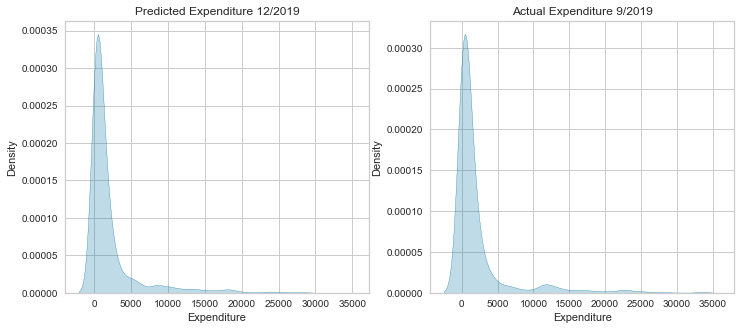

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
sns.kdeplot(data=df_for_test_LGBM['Expenditure'], shade=True, ax=axs[0])
sns.kdeplot(data=df_for_train[(df_for_train['Year']==2019)&(df_for_train['Month']==9)]['Expenditure'], shade=True, ax=axs[1])
axs[0].set_title("Predicted Expenditure 12/2019")
axs[1].set_title("Actual Expenditure 9/2019")
plt.show()

In [38]:
df_for_test_LGBM.describe()['Expenditure']

count    5214.000
mean     2108.079
std      3976.446
min         7.117
25%       216.610
50%       687.121
75%      1821.899
max     33245.215
Name: Expenditure, dtype: float64

In [39]:
df_for_train[(df_for_train['Year']==2019)&(df_for_train['Month']==9)].describe()['Expenditure']

count    5214.000
mean     2194.736
std      4642.673
min         0.000
25%       118.672
50%       593.295
75%      1695.122
max     33592.750
Name: Expenditure, dtype: float64

In [49]:
df_for_test_LGBM.to_csv('LGBM prediction in quarterly scale for time series-no moving average 12 months.csv')

In [51]:
df_for_test_LGBM.head()

,MemberID,Year,Month,YOB,MemberGender,MemberRace,ZipCode,Total Claims,PART A CLAIMS,PART B CLAIMS,PART D CLAIMS,ED_Vists,Admissions,PCP_Visits,RISK SCORE,SNF COUNT,HOSPITAL LOS,HCC_1,HCC_2,HCC_6,HCC_8,HCC_9,HCC_10,HCC_11,HCC_12,HCC_17,HCC_18,HCC_19,HCC_21,HCC_22,HCC_23,HCC_27,HCC_28,HCC_29,HCC_33,HCC_34,HCC_35,HCC_39,HCC_40,HCC_46,HCC_47,HCC_48,HCC_51,HCC_52,HCC_55,HCC_56,HCC_57,HCC_58,HCC_59,...,HCC_71,HCC_72,HCC_73,HCC_74,HCC_75,HCC_76,HCC_77,HCC_78,HCC_79,HCC_80,HCC_82,HCC_83,HCC_84,HCC_85,HCC_86,HCC_87,HCC_88,HCC_96,HCC_99,HCC_100,HCC_103,HCC_104,HCC_106,HCC_107,HCC_108,HCC_110,HCC_111,HCC_112,HCC_114,HCC_115,HCC_122,HCC_124,HCC_134,HCC_135,HCC_136,HCC_137,HCC_138,HCC_157,HCC_158,HCC_159,HCC_161,HCC_162,HCC_166,HCC_167,HCC_169,HCC_170,HCC_173,HCC_176,Expenditure
0,1A00M09YA30,2019,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.862
1,1A29RM3DF55,2019,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2387.670
2,1A33VV0CD74,2019,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.950
3,1A46T20RF56,2019,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.752
4,1A49E05WX41,2019,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21161.632


**LSTM Model prediction**

12/2019 prediction

In [41]:
columns = df_for_train.drop(['MemberID', 'Year', 'Month'], axis=1).columns
df_for_prediction_2019_12 = concat_df_for_prediction(df_for_train, df_for_test1, Year=2019, Month=12, features=columns)
Enpenditure_2019_12_predict = predicting(df_for_prediction_2019_12, X_train.columns, 2019, 12, model=LSTM_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [05:07<00:00,  3.20s/it]


In [42]:
Enpenditure_2019_12_predict = Enpenditure_2019_12_predict[:,0,0]
Enpenditure_2019_12_predict = Enpenditure_2019_12_predict*(y_train.max()-y_train.min()) + y_train.min()

In [43]:
count = 0

for num in Enpenditure_2019_12_predict:
    if num < 0:
        count += 1
count

348

In [44]:
df_for_test_LSTM = df_for_test1.copy()
df_for_test_LSTM['Expenditure'] = Enpenditure_2019_12_predict
df_for_test_LSTM['Expenditure'] = df_for_test_LSTM['Expenditure'].apply(lambda x: 0 if x<0 else x)

In [45]:
df_for_test_LSTM.describe()['Expenditure']

count    5214.000
mean     2078.747
std      3849.766
min         0.000
25%       236.759
50%       742.689
75%      1874.005
max     31572.111
Name: Expenditure, dtype: float64

In [46]:
df_for_train[(df_for_train['Year']==2019)&(df_for_train['Month']==9)].describe()['Expenditure']

count    5214.000
mean     2194.736
std      4642.673
min         0.000
25%       118.672
50%       593.295
75%      1695.122
max     33592.750
Name: Expenditure, dtype: float64

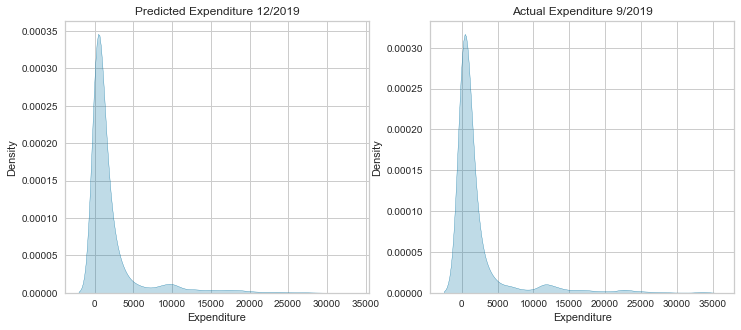

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
sns.kdeplot(data=df_for_test_LSTM['Expenditure'], shade=True, ax=axs[0])
sns.kdeplot(data=df_for_train[(df_for_train['Year']==2019)&(df_for_train['Month']==9)]['Expenditure'], shade=True, ax=axs[1])
axs[0].set_title("Predicted Expenditure 12/2019")
axs[1].set_title("Actual Expenditure 9/2019")
plt.show()

In [50]:
df_for_test_LSTM.to_csv('LSTM prediction in quarterly scale for time series-no moving average 12 months.csv')

In [52]:
df_for_test_LSTM.head()

,MemberID,Year,Month,YOB,MemberGender,MemberRace,ZipCode,Total Claims,PART A CLAIMS,PART B CLAIMS,PART D CLAIMS,ED_Vists,Admissions,PCP_Visits,RISK SCORE,SNF COUNT,HOSPITAL LOS,HCC_1,HCC_2,HCC_6,HCC_8,HCC_9,HCC_10,HCC_11,HCC_12,HCC_17,HCC_18,HCC_19,HCC_21,HCC_22,HCC_23,HCC_27,HCC_28,HCC_29,HCC_33,HCC_34,HCC_35,HCC_39,HCC_40,HCC_46,HCC_47,HCC_48,HCC_51,HCC_52,HCC_55,HCC_56,HCC_57,HCC_58,HCC_59,...,HCC_71,HCC_72,HCC_73,HCC_74,HCC_75,HCC_76,HCC_77,HCC_78,HCC_79,HCC_80,HCC_82,HCC_83,HCC_84,HCC_85,HCC_86,HCC_87,HCC_88,HCC_96,HCC_99,HCC_100,HCC_103,HCC_104,HCC_106,HCC_107,HCC_108,HCC_110,HCC_111,HCC_112,HCC_114,HCC_115,HCC_122,HCC_124,HCC_134,HCC_135,HCC_136,HCC_137,HCC_138,HCC_157,HCC_158,HCC_159,HCC_161,HCC_162,HCC_166,HCC_167,HCC_169,HCC_170,HCC_173,HCC_176,Expenditure
0,1A00M09YA30,2019,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.146
1,1A29RM3DF55,2019,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2525.891
2,1A33VV0CD74,2019,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,338.050
3,1A46T20RF56,2019,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,1A49E05WX41,2019,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22701.812
